### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [88]:
import pandas as pd
import numpy as np

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [89]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales,num_baskets
count,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000
mean,0.870646,733.105023,53.751262,209.747176,210.612409,62.222123,3.552271
std,0.816643,1061.519728,55.617563,197.669931,260.782225,48.365995,3.748938
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000,1.000000
25%,-0.000000,152.000000,15.000000,80.000000,49.680000,27.700000,1.000000
50%,0.693147,355.000000,34.000000,150.000000,118.350000,49.935000,2.000000
75%,1.386294,876.000000,73.000000,268.000000,262.300000,84.610000,4.000000
max,3.295837,13162.000000,315.000000,1440.000000,2143.240000,318.190000,27.000000


In [90]:
# first try with tot_sales
def label_by_quantiles(label_feature, quantiles):
    if (label_feature < quantiles[10]):
        return "low"
    elif (label_feature < quantiles[15]):
        return "medium"
    else:
        return "high"

def set_label(labelFeature):
    quantiles = []
    
    for i in range(0, 100, 5):
        quantile = indicators[labelFeature].quantile(i/100)
        quantiles.append(quantile)
        #print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))
        
    df = indicators.copy(deep=True)
    df["spending_profile"] = df[LABEL_FEATURE].apply(lambda x : label_by_quantiles(x, quantiles))
    
    return df

In [91]:
df = set_label(LABEL_FEATURE)
print(df)

             Entropy     i   iu  imax  tot_sales  mean_sales  num_baskets  \
CustomerID                                                                  
12347       1.945910  2458  103   319     481.21   68.744286            7   
12348       1.386294  2341   22  1254     178.71   44.677500            4   
12350      -0.000000   197   17   197      65.30   65.300000            1   
12352       2.079442   473   59    98    1337.42  167.177500            8   
12353      -0.000000    20    4    20      24.30   24.300000            1   
...              ...   ...  ...   ...        ...         ...          ...   
18280      -0.000000    45   10    45      47.65   47.650000            1   
18281      -0.000000    54    7    54      39.36   39.360000            1   
18282       0.693147   103   12    75      62.39   31.195000            2   
18283       2.566599  1357  263    61    1174.33   73.395625           16   
18287       1.098612  1586   59   488     104.55   34.850000            3   

### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

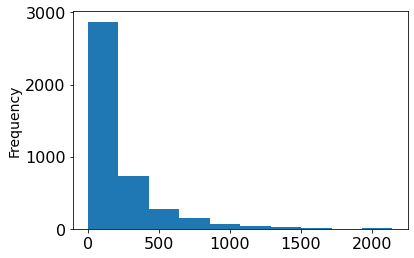

In [92]:
df[LABEL_FEATURE].plot.hist()

We drop the column we used to compute our label in order to proceed with classification

In [93]:
df = df.drop(LABEL_FEATURE, axis=1)

## Discretizing the label

In [94]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [95]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['spending_profile']
df = discretize_data(df, variables)

## Splitting the dataset

In [96]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

# discretized sets
train_set_discretized = train_set.copy(deep=True)
test_set_discretized = test_set.copy(deep=True)

train_set = train_set.drop('spending_profile_num', axis=1)
test_set = test_set.drop('spending_profile_num', axis=1)

## Classifier Collection

In [97]:
#metrics computed on the test set
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
import statistics 

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

def classification(clf, parameters=None, pscore=True):
    
    if parameters is None:
        classifier = clf
    else:
        classifier = clf(**parameters)
        
    classifier = classifier.fit(train_set, train_label)
    test_pred_clf = classifier.predict(test_set)
    train_pred_clf = classifier.predict(train_set)
    if pscore is True:
        print("============== score report ==============")
        report_scores(test_label, test_pred_clf)
        print("============== accuracy report ==============\n")
        accuracy_on_train(test_pred_clf,train_pred_clf)
        print("\n============== cross report ==============\n")
        clf_cross_validate(classifier)
    
    return classifier

def optimized_hyperparameters(clf, params_range, pscore=True):
    
    rndsearch = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
    
    #run the rndsearch
    rndsearch.fit(train_set, train_label)
    
    if pscore is True:
        print('Mean and std of this setting ', 
              rndsearch.cv_results_['mean_test_score'][0], 
              rndsearch.cv_results_['std_test_score'][0])
        
    return rndsearch.cv_results_['params'][0]

#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
def accuracy_on_train(test_pred_clf,train_pred_clf):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_clf))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_clf))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_clf, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_clf, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_clf, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_clf))
    

#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
def clf_cross_validate(clf):
    scores = cross_validate(clf, train_set, train_label, cv=3, return_train_score= True)
    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('Train score ', statistics.mean(scores['train_score']))

## Classification with Decision Tree

In [98]:
from sklearn import tree

param_dict = {"min_samples_split": 3,
              "min_samples_leaf": 4,
              "max_depth": 10,
              "criterion": "gini",
              "splitter": "best"}

dt = classification(tree.DecisionTreeClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.95      0.93      0.94       521
      medium       0.98      0.98      0.98      1040
        high       0.89      0.91      0.90       520

    accuracy                           0.95      2081
   macro avg       0.94      0.94      0.94      2081
weighted avg       0.95      0.95      0.95      2081

============== accuracy report ==============

Accuracy train set  0.9721153846153846
Accuracy test set  0.9490629505045651
Precision train set  0.9726728004755728
Recall train set  0.9721153846153846
F1 score train set  0.9722788012885853
Support train set  (array([0.96875   , 0.99708171, 0.92777778]), array([0.95384615, 0.98557692, 0.96346154]), array([0.96124031, 0.99129594, 0.94528302]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.006589174270629883
Score time  0.002543369928995768
Test score  0.9461549764143424
Train score  0

In [99]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True, rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_png('../output/task3/graphviz_dt.png')

True

In [100]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [101]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 484,    0,   37],
       [   0, 1016,   24],
       [  27,   18,  475]])

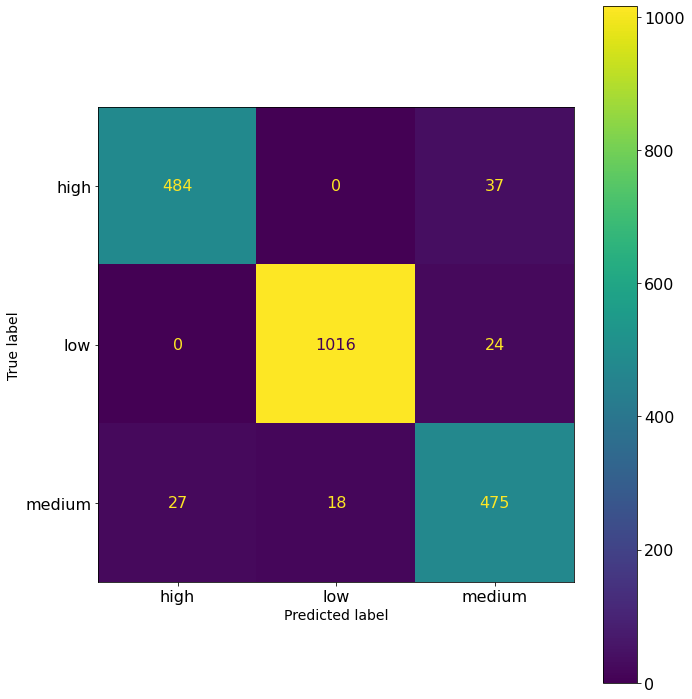

In [102]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.tight_layout()
plt.savefig('../output/task3/confusionmatrix.png')
plt.show() 

## Classification with Naive Bayes

In [103]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = classification(GaussianNB())

============== score report ==============
              precision    recall  f1-score   support

         low       0.89      0.71      0.79       521
      medium       0.88      0.90      0.89      1040
        high       0.60      0.69      0.64       520

    accuracy                           0.80      2081
   macro avg       0.79      0.77      0.77      2081
weighted avg       0.81      0.80      0.80      2081

============== accuracy report ==============

Accuracy train set  0.8091346153846154
Accuracy test set  0.7991350312349832
Precision train set  0.8172107479152975
Recall train set  0.8091346153846154
F1 score train set  0.8105851165191316
Support train set  (array([0.8735363 , 0.88930582, 0.61669506]), array([0.71730769, 0.91153846, 0.69615385]), array([0.78775079, 0.9002849 , 0.65401987]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.003934462865193685
Score time  0.0020964940388997397
Test score  0.8076871362173956
Train score  

## Classification with Random Forest

In [104]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier

params_dict = {
    'n_estimators' : 30, 
    'criterion' : 'gini',
    'max_features' : 3,
    'max_depth' : 4, 
    'min_samples_split' : 2,
    'min_samples_leaf' : 8,
    'bootstrap' : True
}

rf = classification(RandomForestClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.94      0.88      0.91       521
      medium       0.95      0.95      0.95      1040
        high       0.79      0.84      0.82       520

    accuracy                           0.90      2081
   macro avg       0.89      0.89      0.89      2081
weighted avg       0.91      0.90      0.91      2081

============== accuracy report ==============

Accuracy train set  0.9129807692307692
Accuracy test set  0.9048534358481499
Precision train set  0.9143134775420685
Recall train set  0.9129807692307692
F1 score train set  0.9133369776524507
Support train set  (array([0.93469388, 0.9541109 , 0.81433824]), array([0.88076923, 0.95961538, 0.85192308]), array([0.90693069, 0.95685523, 0.83270677]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.05917708079020182
Score time  0.006483157475789388
Test score  0.8817223975725417
Train score  0.

### Volendo il random forest può essere "migliorato" e tunato in vari modi. Ne vale la pena? Forse no. Guarda il notebook adult_classification

The performance is may slightly worse for the randomized search, and is likely due to a noise effect and would not carry over to a held-out test set.

Note that in practice, one would not search over this many different parameters simultaneously using grid search, but pick only the ones deemed most important.

In [105]:
#to find the best set of parameter setting, we can run a grid search
from scipy.stats import randint as sp_randint

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

#define the model
clf = RandomForestClassifier(n_estimators=30)
rs = optimized_hyperparameters(clf, param_dist)
                               
optimized_rf = classification(RandomForestClassifier,rs)

Mean and std of this setting  0.8129807692307691 0.028458939590286038
============== score report ==============
              precision    recall  f1-score   support

         low       0.84      0.79      0.81       521
      medium       0.92      0.85      0.88      1040
        high       0.59      0.72      0.65       520

    accuracy                           0.80      2081
   macro avg       0.78      0.79      0.78      2081
weighted avg       0.82      0.80      0.81      2081

============== accuracy report ==============

Accuracy train set  0.8100961538461539
Accuracy test set  0.8015377222489188
Precision train set  0.8214047077579537
Recall train set  0.8100961538461539
F1 score train set  0.8143844639866357
Support train set  (array([0.82307692, 0.9253886 , 0.61176471]), array([0.82307692, 0.85865385, 0.7       ]), array([0.82307692, 0.89077307, 0.6529148 ]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.12056159973144531
Score tim

## Che è sta roba? perché c'è sto terzo caso? bho!

In [106]:
param_dict = {
    'n_estimators':30, 
    'criterion':'gini',
    'max_features':3,
    'max_depth':6, 
    'min_samples_split':32,
    'min_samples_leaf':10,
    'bootstrap':False,
    'class_weight':'balanced'
}
rf = classification(RandomForestClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.96      0.90      0.93       521
      medium       1.00      0.93      0.96      1040
        high       0.80      0.96      0.87       520

    accuracy                           0.93      2081
   macro avg       0.92      0.93      0.92      2081
weighted avg       0.94      0.93      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9504807692307692
Accuracy test set  0.9279192695819317
Precision train set  0.9554207801352096
Recall train set  0.9504807692307692
F1 score train set  0.9515378103798884
Support train set  (array([0.97211155, 0.99898477, 0.85160202]), array([0.93846154, 0.94615385, 0.97115385]), array([0.95499022, 0.97185185, 0.90745732]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.06579105059305827
Score time  0.006410678227742513
Test score  0.9245286680445182
Train score  0.

## AdaBoost

In [107]:
from sklearn.ensemble import AdaBoostClassifier

params_dict = {
    'n_estimators' : 100,
    'random_state' : 0
}

ada = classification(AdaBoostClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       1.00      0.79      0.88       521
      medium       0.98      0.94      0.96      1040
        high       0.74      0.96      0.84       520

    accuracy                           0.91      2081
   macro avg       0.91      0.90      0.89      2081
weighted avg       0.92      0.91      0.91      2081

============== accuracy report ==============

Accuracy train set  0.9163461538461538
Accuracy test set  0.9062950504565113
Precision train set  0.9305203449186179
Recall train set  0.9163461538461538
F1 score train set  0.9181876433821441
Support train set  (array([0.98352941, 0.98701299, 0.76452599]), array([0.80384615, 0.95      , 0.96153846]), array([0.88465608, 0.96815287, 0.85178876]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.2626994450887044
Score time  0.024378061294555664
Test score  0.8499957721859739
Train score  0.8

## Classification with KNN

In [108]:
from sklearn.neighbors import KNeighborsClassifier

params_dict = {
    'n_neighbors' : 2,
    'algorithm' : 'ball_tree',
    'metric' : 'minkowski'
}

knn = classification(KNeighborsClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.71      0.83      0.76       521
      medium       0.84      0.93      0.88      1040
        high       0.65      0.40      0.50       520

    accuracy                           0.77      2081
   macro avg       0.73      0.72      0.71      2081
weighted avg       0.76      0.77      0.75      2081

============== accuracy report ==============

Accuracy train set  0.8961538461538462
Accuracy test set  0.7698222008649688
Precision train set  0.9094739803094234
Recall train set  0.8961538461538462
F1 score train set  0.8888656766268788
Support train set  (array([0.82278481, 0.90755556, 1.        ]), array([1.        , 0.98173077, 0.62115385]), array([0.90277778, 0.94318707, 0.76631079]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.0035260518391927085
Score time  0.031309286753336586
Test score  0.7807628917139003
Train score  

## Classification with SVM

In [109]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

params_dict = {
    'kernel' : 'sigmoid',
    'C' : 0.5,
    'gamma' : 'scale',
    'probability' : True
}

svm = classification(SVC,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.36      0.56      0.44       521
      medium       0.66      0.75      0.70      1040
        high       0.43      0.08      0.14       520

    accuracy                           0.54      2081
   macro avg       0.49      0.47      0.43      2081
weighted avg       0.53      0.54      0.50      2081

============== accuracy report ==============

Accuracy train set  0.5293269230769231
Accuracy test set  0.5372417107160019
Precision train set  0.525984202589018
Recall train set  0.5293269230769231
F1 score train set  0.4921806043943307
Support train set  (array([0.35797665, 0.64612823, 0.4537037 ]), array([0.53076923, 0.74615385, 0.09423077]), array([0.42757552, 0.69254797, 0.15605096]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.24330496788024902
Score time  0.01924292246500651
Test score  0.565397352140868
Train score  0.570

## Classification with Voting - classification over the previous classifier

In [110]:
from sklearn.ensemble import VotingClassifier

params_dict = {
    'estimators' : [],
    'voting' : 'soft'
}

params_dict['estimators'] = [('rf', rf), ('dt', dt), ('gnb', gnb), ("knn", knn), ("svm", svm), ("ada", clf)]

voting = classification(VotingClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.95      0.89      0.92       521
      medium       0.97      0.97      0.97      1040
        high       0.86      0.90      0.88       520

    accuracy                           0.93      2081
   macro avg       0.92      0.92      0.92      2081
weighted avg       0.94      0.93      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9889423076923077
Accuracy test set  0.9346468044209515
Precision train set  0.9890065013111887
Recall train set  0.9889423076923077
F1 score train set  0.9889454086950981
Support train set  (array([0.98828125, 0.99807692, 0.97159091]), array([0.97307692, 0.99807692, 0.98653846]), array([0.98062016, 0.99807692, 0.97900763]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.3665364583333333
Score time  0.037714640299479164
Test score  0.9360588179031983
Train score  0.9

## Plotting the results

In [111]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

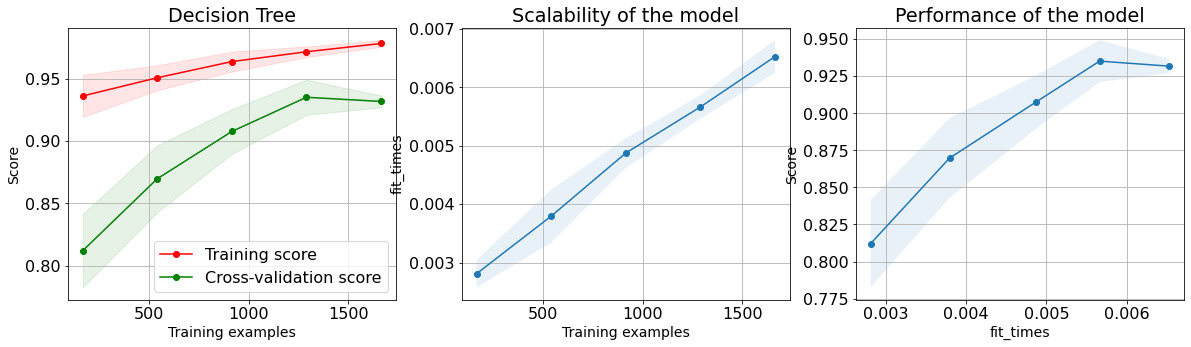

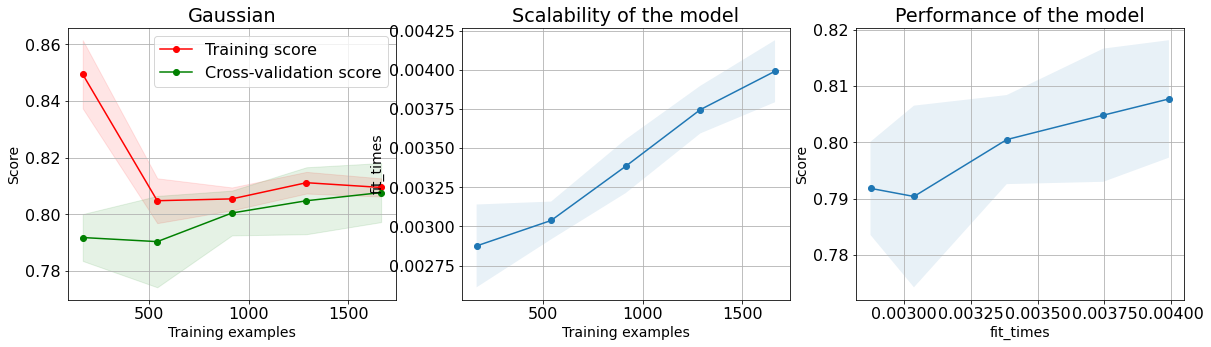

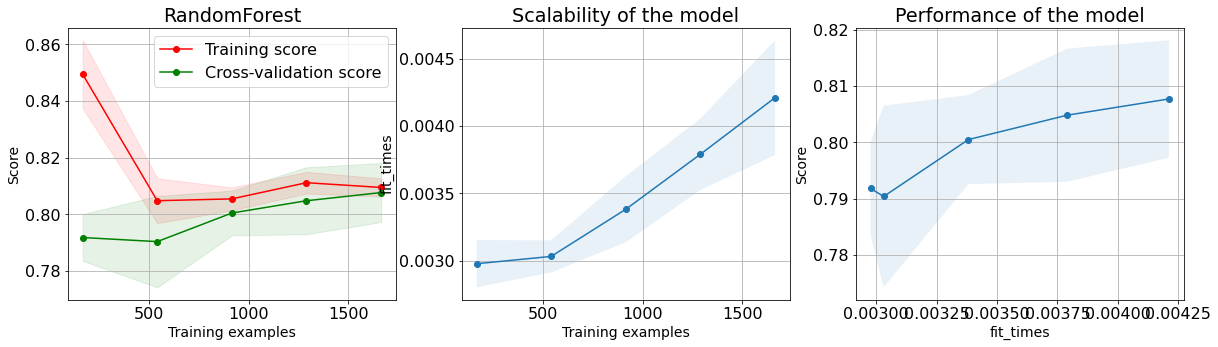

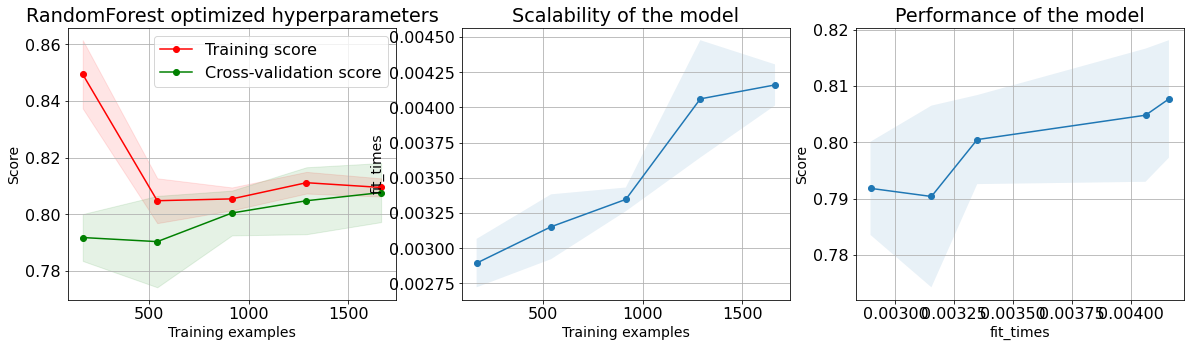

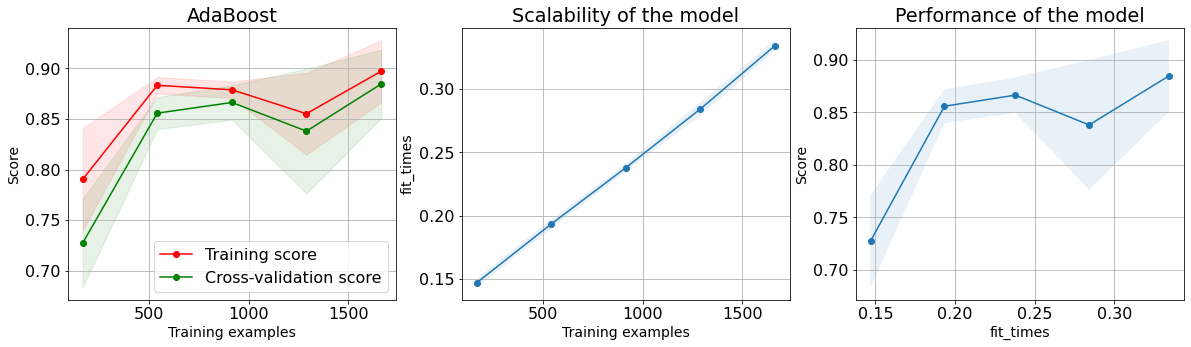

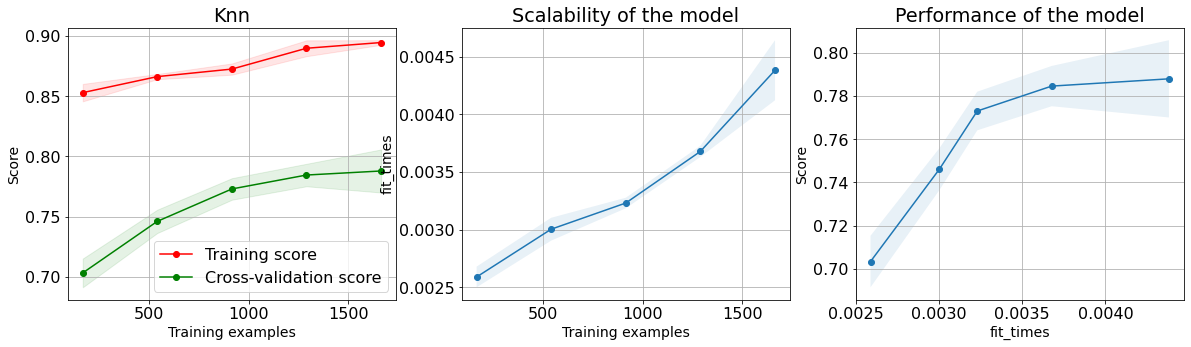

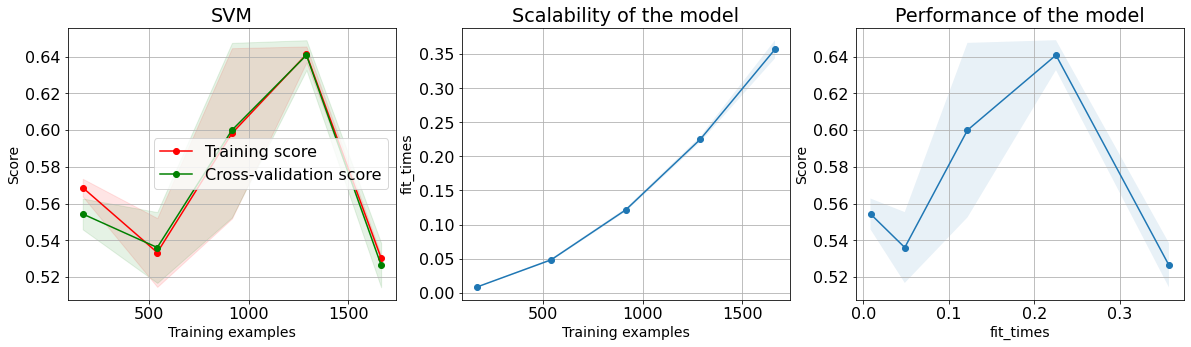

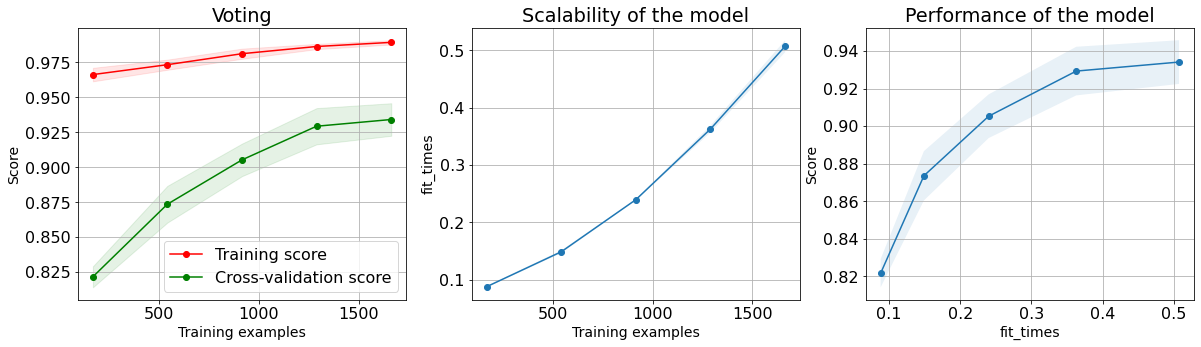

In [116]:
dt_plt = plot_learning_curve(dt,title="Decision Tree",X=train_set,y=train_label)
dt_plt.savefig('../output/task3/dt_plt.png')

gnb_plt = plot_learning_curve(gnb,title="Gaussian",X=train_set,y=train_label)
gnb_plt.savefig('../output/task3/gnb_plt.png')

rf_plt = plot_learning_curve(gnb,title="RandomForest",X=train_set,y=train_label)
rf_plt.savefig('../output/task3/rf_plt.png')

rf_optimized_plt = plot_learning_curve(gnb,title="RandomForest optimized hyperparameters",X=train_set,y=train_label)
rf_optimized_plt.savefig('../output/task3/rf_optimized_plt.png')

ada_plt = plot_learning_curve(ada,title="AdaBoost",X=train_set,y=train_label)
ada_plt.savefig('../output/task3/ada_plt.png')

knn_plt = plot_learning_curve(knn,title="Knn",X=train_set,y=train_label)
knn_plt.savefig('../output/task3/knn_plt.png')

svm_plt = plot_learning_curve(svm,title="SVM",X=train_set,y=train_label)
svm_plt.savefig('../output/task3/svm_plt.png')

voting_plt = plot_learning_curve(voting,title="Voting",X=train_set,y=train_label)
voting_plt.savefig('../output/task3/voting_plt.png')